## Main code

In [2]:
import scipy
import scipy.linalg as linalg
import numpy as np
#!pip install igraph
import igraph as ig
import random
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
class NOTEARS:
  def __init__(self, weight_threshold, max_rho, max_iter, h_tol, lambda1, originalMethod = False):
    self.X = None
    self.weight_threshold = weight_threshold
    self.max_rho = max_rho
    self.max_iter = max_iter
    self.h_tol = h_tol
    self.lambda1 = lambda1
    self.rho = 1.0
    self.alpha = 1.0
    self.h = np.inf
    self.originalMethod = originalMethod
    self.b = 1.5

  def calc_h(self, W_flattened):
    d = self.X.shape[1]
    #W = W_flattened.reshape([d, d])
    W = self._adj(W_flattened)
    M = linalg.expm(W*W)
    h = np.trace(M) - d
    h_grad = 2* M.T * W
    return h, h_grad


  # Doesn't include regularization term
  def objective_and_gradient(self, W_flattened):
      d = self.X.shape[1]
      n = self.X.shape[0]

      #W = W_flattened.reshape([d, d])
      W = self._adj(W_flattened)

      # Just lasso regression loss
      R = self.X - self.X @ W
      loss = 1/(2*n) * (R**2).sum()
      grad_loss = -1.0/n * self.X.T @ R
      h, h_grad = self.calc_h(W_flattened)

      #objective_value = loss + self.rho/2 * h**2 + self.alpha*h
      #objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      #objective_gradient = np.concatenate((objective_gradient + self.lambda1, []), axis=None)

      objective_value = loss + self.rho/2 * h**2 + self.alpha*h + self.lambda1*np.abs(W).sum()
      objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      objective_gradient = np.concatenate((objective_gradient + self.lambda1, - objective_gradient + self.lambda1), axis=None)
      return objective_value, objective_gradient

  def _adj(self, w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        # Note doubled variables are for handling non-smooth regularization term
        return (w[:d * d] - w[d * d:]).reshape([d, d])


  def solve(self):
      d = self.X.shape[1]
      n = self.X.shape[0]
      # Starting guess for W; initialize rho, alpha
      W_est_flattened, self.rho, self.alpha = np.zeros(2*d*d), 1.0, 0.0
      rho_s = []
      alphas = []

      # Set bounds for W_est matrix (basically diagonal elements must be zero.)
      #bnds = [(0, 0) if i == j else (0, None) for i in range(d) for j in range(d)]
      bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]

      # Perform Dual Gradient ascent to solve eq. (12) in paper
      if self.originalMethod:
              # Perform Dual Gradient ascent to solve eq. (12) in paper
          # Perform Dual Gradient ascent to solve eq. (12) in paper
          for i in range(1, self.max_iter, 1):
              rho_s.append(self.rho)
              alphas.append(self.alpha)
              print("Iteration " + str(i))

              while self.rho < self.max_rho:
                  W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds).x
                  #print(W_next_flattened)
                  h_next, _ = self.calc_h(W_next_flattened)
                  #print(h_next)
                  if h_next > 0.25*self.h: self.rho*= 10
                  else: break

              W_est_flattened = W_next_flattened
              self.h = h_next
              self.alpha = self.alpha + self.rho*self.h
              print(self.h)
              #print(W_est_flattened.reshape([d, d]))

              if self.h <= self.h_tol or self.rho >= self.max_rho: break
          # Threshold values lower than weight_threshold (omega)
          #W_est = W_est_flattened.reshape([d, d])
          W_est = self._adj(W_est_flattened)
          W_est[np.abs(W_est)< self.weight_threshold] = 0
          assert self.is_dag(W_est)
          np.savetxt('W_est.csv', W_est, delimiter=',')


          accuracy = self.count_accuracy(B_true, W_est != 0)
          print(accuracy)

      else:
        h_vals = []
        h_init, _ = self.calc_h(W_est_flattened)
        #curr_h = h_init
        factor = 1
        alpha_init = self.alpha
        i = 1
        for iter in range(1, self.max_iter, 1):
            # Update rho
            self.rho = factor * self.b**i
            # Update tolerance
            epsilon_i = (1/self.rho)**0.25#**0.025
            rho_s.append(self.rho)
            alphas.append(self.alpha)
            print("Iteration " + str(iter))

            while self.rho < self.max_rho:
                  i+=1
                  W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i }).x
                  #print(W_next_flattened)
                  h_next, _ = self.calc_h(W_next_flattened)
                  if h_next > 0.25*self.h:
                    factor*= 10
                    # Update rho
                    self.rho = factor * self.b**i
                    # Update tolerance
                    epsilon_i = (1/self.rho)**0.25
                  else: break

            #W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient,
            #                                           W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i }).x
            #h_next, _ = self.calc_h(W_next_flattened)
            print(h_next)

            W_est_flattened = W_next_flattened
            self.h = h_next


            #Update alpha
            dual_step_size = self.rho*np.minimum(1, 1*np.log(2)**2/(self.h*(i+1)*np.log(i+2)**2))
            #self.alpha = self.alpha + self.rho*self.h
            self.alpha = self.alpha + dual_step_size*self.h
            i+=1


            if self.h <= self.h_tol or self.rho >= self.max_rho:
              self.rho = self.max_rho
              W_est_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds).x
              self.h, _ = self.calc_h(W_next_flattened)
              break

        # Threshold values lower than weight_threshold (omega)
        W_est = self._adj(W_est_flattened)
        W_est[np.abs(W_est)< self.weight_threshold] = 0
        assert self.is_dag(W_est)
        np.savetxt('W_est.csv', W_est, delimiter=',')


        accuracy = self.count_accuracy(B_true, W_est != 0)
        print(accuracy)

      print(self.objective_and_gradient)
      return W_est, rho_s, alphas, accuracy


  ### Helper functions to generate/simulate DAG (i.e. our synthetic data) (copied from NOTEARS code)
  def is_dag(self, W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

  def simulate_parameter(self, B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


  def simulate_dag(self, d, s0, graph_type):
      """Simulate random DAG with some expected number of edges.

      Args:
          d (int): num of nodes
          s0 (int): expected num of edges
          graph_type (str): ER, SF, BP

      Returns:
          B (np.ndarray): [d, d] binary adj matrix of DAG
      """
      def _random_permutation(M):
          # np.random.permutation permutes first axis only
          P = np.random.permutation(np.eye(M.shape[0]))
          return P.T @ M @ P

      def _random_acyclic_orientation(B_und):
          return np.tril(_random_permutation(B_und), k=-1)

      def _graph_to_adjmat(G):
          return np.array(G.get_adjacency().data)

      if graph_type == 'ER':
          # Erdos-Renyi
          G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
          B_und = _graph_to_adjmat(G_und)
          B = _random_acyclic_orientation(B_und)
      elif graph_type == 'SF':
          # Scale-free, Barabasi-Albert
          G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
          B = _graph_to_adjmat(G)
      elif graph_type == 'BP':
          # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
          top = int(0.2 * d)
          G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
          B = _graph_to_adjmat(G)
      else:
          raise ValueError('unknown graph type')
      B_perm = _random_permutation(B)
      assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
      return B_perm

  def simulate_linear_sem(self, W, n, sem_type, noise_scale=None):
      """Simulate samples from linear SEM with specified type of noise.

      For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

      Args:
          W (np.ndarray): [d, d] weighted adj matrix of DAG
          n (int): num of samples, n=inf mimics population risk
          sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
          noise_scale (np.ndarray): scale parameter of additive noise, default all ones

      Returns:
          X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
      """
      def _simulate_single_equation(X, w, scale):
          """X: [n, num of parents], w: [num of parents], x: [n]"""
          if sem_type == 'gauss':
              z = np.random.normal(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'exp':
              z = np.random.exponential(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'gumbel':
              z = np.random.gumbel(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'uniform':
              z = np.random.uniform(low=-scale, high=scale, size=n)
              x = X @ w + z
          elif sem_type == 'logistic':
              x = np.random.binomial(1, scipy.special.expit(X @ w)) * 1.0
          elif sem_type == 'poisson':
              x = np.random.poisson(np.exp(X @ w)) * 1.0
          else:
              raise ValueError('unknown sem type')
          return x

      d = W.shape[0]
      if noise_scale is None:
          scale_vec = np.ones(d)
      elif np.isscalar(noise_scale):
          scale_vec = noise_scale * np.ones(d)
      else:
          if len(noise_scale) != d:
              raise ValueError('noise scale must be a scalar or has length d')
          scale_vec = noise_scale
      if not self.is_dag(W):
          raise ValueError('W must be a DAG')
      if np.isinf(n):  # population risk for linear gauss SEM
          if sem_type == 'gauss':
              # make 1/d X'X = true cov
              X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
              return X
          else:
              raise ValueError('population risk not available')
      # empirical risk
      G = ig.Graph.Weighted_Adjacency(W.tolist())
      ordered_vertices = G.topological_sorting()
      assert len(ordered_vertices) == d
      X = np.zeros([n, d])
      for j in ordered_vertices:
          parents = G.neighbors(j, mode=ig.IN)
          X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
      return X

  def count_accuracy(self, B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not self.is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

Sample test run

In [ ]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 2000, 150, 250, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
np.savetxt('X.csv', solver.X, delimiter=',')

In [ ]:
%%time
W_est, rhos, alphas, _ = solver.solve()

Iteration 1
2.284294980164134
Iteration 2
0.18846062401200925
Iteration 3
0.04356892292383918
Iteration 4
0.003713943372531503
Iteration 5
0.0009095473501758988
Iteration 6
8.633279378500447e-05
Iteration 7
8.054139470914379e-06
Iteration 8
1.4727385746482469e-06
Iteration 9
2.1604586208923138e-07
Iteration 10
2.6050912538266857e-08
Iteration 11
1.718643716230872e-08
{'fdr': 0.1543859649122807, 'tpr': 0.964, 'fpr': 0.00402745995423341, 'shd': 51, 'nnz': 285}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa7601553c0>>
CPU times: user 1h 6min 21s, sys: 57min 9s, total: 2h 3min 30s
Wall time: 1h 11min 11s


In [ ]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X

In [ ]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ = solver2.solve()

Iteration 1
1.9588369172437865
Iteration 2
0.29972740095988115
Iteration 3
0.0413897726675998
Iteration 4
0.005399932526188422
Iteration 5
0.0006968060370695639
Iteration 6
0.00010677142796566841
Iteration 7
1.8788958470850048e-05
Iteration 8
3.383397086054174e-06
Iteration 9
7.376772259704012e-07
Iteration 10
1.4379941148945363e-07
Iteration 11
2.606935822768719e-08
Iteration 12
1.409523520123912e-08
{'fdr': 0.2948328267477204, 'tpr': 0.928, 'fpr': 0.008878718535469107, 'shd': 109, 'nnz': 329}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa7601547f0>>
CPU times: user 1h 3min 23s, sys: 53min 50s, total: 1h 57min 14s
Wall time: 1h 6min 47s


Text(0.5, 0, 'Iteration')

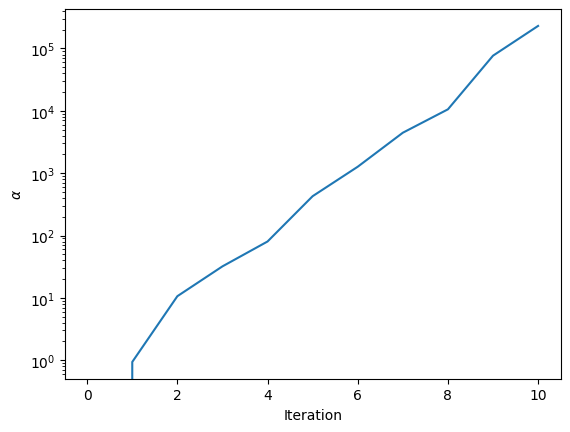

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(alphas)
plt.ylabel(r'$\alpha$')
plt.xlabel('Iteration')


Text(0.5, 0, 'Iteration')

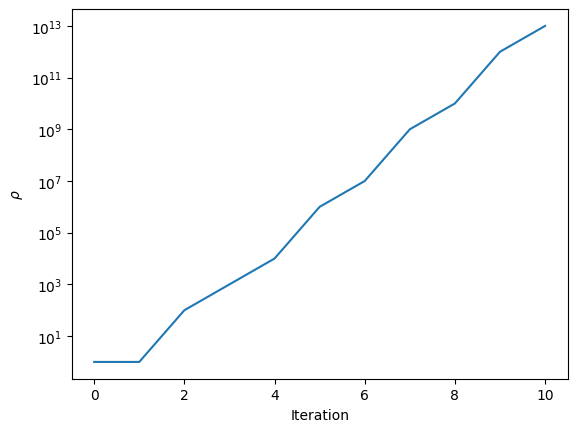

In [ ]:
plt.semilogy(rhos)
plt.ylabel(r'$\rho$')
plt.xlabel('Iteration')

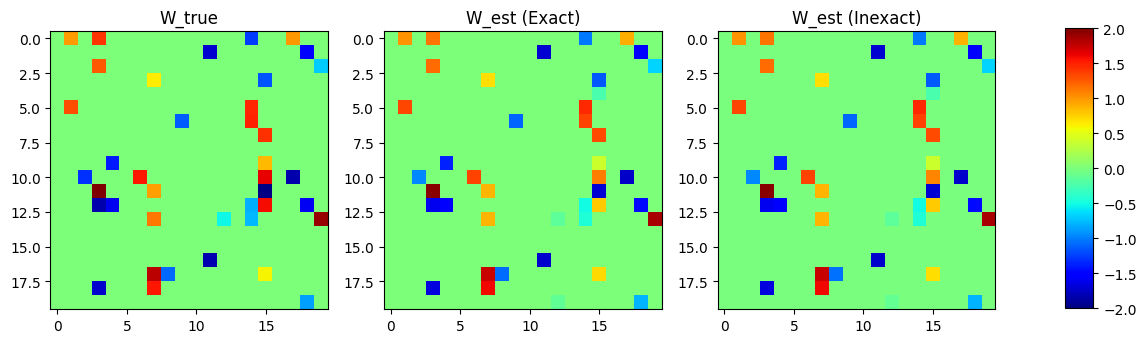

In [ ]:
import matplotlib.pyplot as plt
sns.reset_orig()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

#for ax in axes.flat:
im = ax1.imshow(W_true, vmin=-2, vmax=2, cmap='jet')
ax1.set_title('W_true')
im = ax2.imshow(W_est, vmin=-2, vmax=2, cmap='jet')
ax2.set_title('W_est (Exact)')
im = ax3.imshow(W_est_new_ours, vmin=-2, vmax=2, cmap='jet')
ax3.set_title('W_est (Inexact)')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Plots/Simulations with Synthetic Data

In [14]:
sns.set() # Setting seaborn as default style even if use only matplotlib
plt.show()
import time

d_vals = [10, 20, 40, 60]
num_of_simulations = 10
n = 1000

# Placeholders for metric results for all simulations

'''
full_exp_shd_results_original = []
full_exp_fdr_results_original = []
full_exp_tpr_results_original = []
full_exp_fpr_results_original = []
full_exp_shd_results_ours = []
full_exp_fdr_results_ours = []
full_exp_tpr_results_ours = []
full_exp_fpr_results_ours = []


full_gauss_shd_results_original = []
full_gauss_fdr_results_original = []
full_gauss_tpr_results_original = []
full_gauss_fpr_results_original = []
full_gauss_shd_results_ours = []
full_gauss_fdr_results_ours = []
full_gauss_tpr_results_ours = []
full_gauss_fpr_results_ours = []
'''


full_gumbel_shd_results_original = []
full_gumbel_fdr_results_original = []
full_gumbel_tpr_results_original = []
full_gumbel_fpr_results_original = []
full_gumbel_shd_results_ours = []
full_gumbel_fdr_results_ours = []
full_gumbel_tpr_results_ours = []
full_gumbel_fpr_results_ours = []

# Placeholders for timing results for all simulations
#exp_original_times = []
#gauss_original_times = []
gumbel_original_times = []

#exp_our_times = []
#gauss_our_times = []
gumbel_our_times = []

for graph_type in ['ER']:
    for noise_type in ['gumbel']:
        for d in d_vals:
            for i in np.arange(num_of_simulations + 1):

              print('Starting Simulation #' + str(i+1))
              param_tuple = (graph_type, noise_type, str(d))
              print(", ".join(param_tuple))

              solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
              if graph_type == 'ER':
                n, d, s0, graph_type, sem_type = n, d, 2*d, graph_type, noise_type
              if graph_type == 'SF':
                n, d, s0, graph_type, sem_type = n, d, 4*d, graph_type, noise_type
              solver.d = d
              B_true = solver.simulate_dag(d, s0, graph_type)
              W_true = solver.simulate_parameter(B_true)
              np.savetxt('W_true.csv', W_true, delimiter=',')


              solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
              np.savetxt('X.csv', solver.X, delimiter=',')

              print('Starting Exact Method')
              try:
                start = time.time()
                W_est_new, rhos, alphas, accuracy = solver.solve()
              except Exception: print('')
              stop = time.time()
              duration = stop-start
              #if noise_type == 'exp':
              #  exp_original_times.append(duration)
              #if noise_type == 'gauss':
              #  gauss_original_times.append(duration)
              if noise_type == 'gumbel':
                gumbel_original_times.append(duration)


              solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-7, lambda1= 0.1, originalMethod = False)
              solver2.d = d
              solver2.X = solver.X

              #%%time
              print('Starting Inexact Method')
              try:
                start = time.time()
                W_est_new_ours, rhos_ours, alphas_ours, accuracy_ours = solver2.solve()
              except Exception: print('')
              stop = time.time()
              duration = stop-start
              #if noise_type == 'exp':
              #  exp_our_times.append(duration)
              #if noise_type == 'gauss':
              #  gauss_our_times.append(duration)
              if noise_type == 'gumbel':
                gumbel_our_times.append(duration)

              '''
              if noise_type == 'exp' and graph_type == 'ER':

                full_exp_shd_results_original.append(accuracy["shd"])
                full_exp_tpr_results_original.append(accuracy["tpr"])
                full_exp_fdr_results_original.append(accuracy["fdr"])
                full_exp_fpr_results_original.append(accuracy["fpr"])

                full_exp_shd_results_ours.append(accuracy_ours["shd"])
                full_exp_tpr_results_ours.append(accuracy_ours["tpr"])
                full_exp_fdr_results_ours.append(accuracy_ours["fdr"])
                full_exp_fpr_results_ours.append(accuracy_ours["fpr"])


              if noise_type == 'gauss' and graph_type == 'ER':

                full_gauss_shd_results_original.append(accuracy["shd"])
                full_gauss_tpr_results_original.append(accuracy["tpr"])
                full_gauss_fdr_results_original.append(accuracy["fdr"])
                full_gauss_fpr_results_original.append(accuracy["fpr"])

                full_gauss_shd_results_ours.append(accuracy_ours["shd"])
                full_gauss_tpr_results_ours.append(accuracy_ours["tpr"])
                full_gauss_fdr_results_ours.append(accuracy_ours["fdr"])
                full_gauss_fpr_results_ours.append(accuracy_ours["fpr"])
              '''
            
              if noise_type == 'gumbel' and graph_type == 'ER':

                full_gumbel_shd_results_original.append(accuracy["shd"])
                full_gumbel_tpr_results_original.append(accuracy["tpr"])
                full_gumbel_fdr_results_original.append(accuracy["fdr"])
                full_gumbel_fpr_results_original.append(accuracy["fpr"])

                full_gumbel_shd_results_ours.append(accuracy_ours["shd"])
                full_gumbel_tpr_results_ours.append(accuracy_ours["tpr"])
                full_gumbel_fdr_results_ours.append(accuracy_ours["fdr"])
                full_gumbel_fpr_results_ours.append(accuracy_ours["fpr"])



        '''
        if noise_type == 'exp' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 0], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 0], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")

        if noise_type == 'gauss' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 1], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 1], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")

        if noise_type == 'gumbel' and graph_type == 'SF':
          sns.lineplot(ax=axes[1, 2], x=d_vals, y=shd_results_original, label = 'exact', marker="o")
          sns.lineplot(ax=axes[1, 2], x=d_vals, y=shd_results_ours, label= 'inexact (ours)', marker="o")
        '''


#fig.legend()

Starting Simulation #1
ER, gumbel, 10
Starting Exact Method
Iteration 1
0.6601192626391974
Iteration 2
0.09347425938793208
Iteration 3
0.007877740306845737
Iteration 4
0.001709049938995122
Iteration 5
0.0004007750019709988
Iteration 6
9.348279956888916e-05
Iteration 7
2.112010183807911e-05
Iteration 8
4.131317959732428e-06
Iteration 9
9.370798483843146e-07
Iteration 10
1.824351869572638e-07
Iteration 11
4.410693854595138e-08
Iteration 12
4.3990908693558595e-09
{'fdr': 0.25925925925925924, 'tpr': 1.0, 'fpr': 0.28, 'shd': 7, 'nnz': 27}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CA8967150>>
Starting Inexact Method
Iteration 1
0.5986169210031687
Iteration 2
0.12480113444174457
Iteration 3
0.023903531897971675
Iteration 4
0.002953029880950808
Iteration 5
0.0003236655963707591
Iteration 6
2.881602701876318e-05
Iteration 7
2.846210897189394e-06
Iteration 8
2.8696330112154556e-07
Iteration 9
3.264122483415122e-08
{'fdr': 0.2962962962962963, 'tpr': 0.95

2.6274804502790516e-05
Iteration 7
2.7975053811246653e-06
Iteration 8
3.241629276118374e-07
Iteration 9
3.3255750153671215e-08
{'fdr': 0.18181818181818182, 'tpr': 0.9, 'fpr': 0.16, 'shd': 5, 'nnz': 22}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CA9F3D610>>
Starting Simulation #9
ER, gumbel, 10
Starting Exact Method
Iteration 1
0.5884648392812668
Iteration 2
0.08240773171842264
Iteration 3
0.007629800543135445
Iteration 4
0.0016310078944545836
Iteration 5
0.00035288700862601274
Iteration 6
6.878074892568975e-05
Iteration 7
1.4670406976335926e-05
Iteration 8
3.1597260203852784e-06
Iteration 9
6.810409036717147e-07
Iteration 10
1.4753780064324928e-07
Iteration 11
3.18240509500356e-08
Iteration 12
6.895310988852543e-09
{'fdr': 0.2692307692307692, 'tpr': 0.95, 'fpr': 0.28, 'shd': 7, 'nnz': 26}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CAE1A2690>>
Starting Inexact Method
Iteration 1
0.5300067230092047
Iterat

0.007055973763463896
Iteration 5
0.0004922078883069503
Iteration 6
9.767748340294702e-05
Iteration 7
2.3649779997469977e-05
Iteration 8
2.1708299193790026e-06
Iteration 9
2.2318585024549975e-07
Iteration 10
2.2902110430322864e-08
Iteration 11
6.6489214134435315e-09
{'fdr': 0.15217391304347827, 'tpr': 0.975, 'fpr': 0.04666666666666667, 'shd': 7, 'nnz': 46}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CAE163790>>
Starting Inexact Method
Iteration 1
0.9957835812994666
Iteration 2
0.18184999265439572
Iteration 3
0.025860666748648953
Iteration 4
0.0031690093426348653
Iteration 5
0.0003073814398604213
Iteration 6
3.468839662446044e-05
Iteration 7
4.350231485261702e-06
Iteration 8
7.662624348370173e-07
Iteration 9
1.4016283245155137e-07
Iteration 10
2.724929260011777e-08
{'fdr': 0.15217391304347827, 'tpr': 0.975, 'fpr': 0.04666666666666667, 'shd': 7, 'nnz': 46}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CAE16225

3.1838680314422163e-06
Iteration 9
1.8047765593109943e-07
Iteration 10
1.8851231686767278e-08
Iteration 11
4.297731948099681e-09
{'fdr': 0.13186813186813187, 'tpr': 0.9875, 'fpr': 0.017142857142857144, 'shd': 13, 'nnz': 91}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CAE027A10>>
Starting Inexact Method
Iteration 1
1.3827513156962254
Iteration 2
0.2580007519797789
Iteration 3
0.03789777682221995
Iteration 4
0.004897235380809661
Iteration 5
0.0005494032567980867
Iteration 6
6.70104632405355e-05
Iteration 7
8.853367418737434e-06
Iteration 8
8.74916239013146e-07
Iteration 9
1.106073383994044e-07
Iteration 10
2.1686844320356613e-08
{'fdr': 0.14130434782608695, 'tpr': 0.9875, 'fpr': 0.018571428571428572, 'shd': 14, 'nnz': 92}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CB1C0EBD0>>
Starting Simulation #2
ER, gumbel, 40
Starting Exact Method
Iteration 1
1.3466890946438568
Iteration 2
0.15006502405299216
Iteration

0.22870749895044185
Iteration 3
0.03496082921941479
Iteration 4
0.005219862227278327
Iteration 5
0.0007728950863992168
Iteration 6
0.00012875348599550307
Iteration 7
1.2681451423190993e-05
Iteration 8
1.5043355006127967e-06
Iteration 9
1.4802886028064677e-07
Iteration 10
2.864807413516246e-08
{'fdr': 0.21875, 'tpr': 0.9375, 'fpr': 0.03, 'shd': 24, 'nnz': 96}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CB517C290>>
Starting Simulation #9
ER, gumbel, 40
Starting Exact Method
Iteration 1
1.4232722754842229
Iteration 2
0.14370609073409213
Iteration 3
0.03561265887279319
Iteration 4
0.003330421893736002
Iteration 5
0.0002771245594743732
Iteration 6
6.573312554536415e-05
Iteration 7
1.0008182002252397e-05
Iteration 8
9.118847685840592e-07
Iteration 9
9.078124207917426e-08
Iteration 10
9.597911798664427e-09
{'fdr': 0.10227272727272728, 'tpr': 0.9875, 'fpr': 0.012857142857142857, 'shd': 9, 'nnz': 88}
<bound method NOTEARS.objective_and_gradient of <__mai

1.7046178371060705e-06
Iteration 9
3.195515247966796e-07
Iteration 10
7.629425624600117e-08
{'fdr': 0.24, 'tpr': 0.95, 'fpr': 0.02181818181818182, 'shd': 39, 'nnz': 150}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CB517CA90>>
Starting Simulation #5
ER, gumbel, 60
Starting Exact Method
Iteration 1
1.8924206522112996
Iteration 2
0.17887211512400825
Iteration 3
0.042850706156222884
Iteration 4
0.0034553175292302285
Iteration 5
0.0008453243578117053
Iteration 6
7.989410072184455e-05
Iteration 7
1.9665598678386687e-05
Iteration 8
1.3411865396051326e-06
Iteration 9
1.432344731711055e-07
Iteration 10
3.196041120645532e-08
Iteration 11
9.447902016290755e-09
{'fdr': 0.10687022900763359, 'tpr': 0.975, 'fpr': 0.008484848484848486, 'shd': 17, 'nnz': 131}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x0000028CA9EB2B50>>
Starting Inexact Method
Iteration 1
1.6399111109047126
Iteration 2
0.2824585006377731
Iteration 3
0.039420321

In [23]:
np.save('full_exp_shd_results_original', np.array(full_exp_shd_results_original))
np.save('full_exp_fdr_results_original', np.array(full_exp_fdr_results_original))
np.save('full_exp_tpr_results_original', np.array(full_exp_tpr_results_original))
np.save('full_exp_fpr_results_original', np.array(full_exp_fpr_results_original))
np.save('full_exp_shd_results_ours', np.array(full_exp_shd_results_ours))
np.save('full_exp_fdr_results_ours', np.array(full_exp_fdr_results_ours))
np.save('full_exp_tpr_results_ours', np.array(full_exp_tpr_results_ours))
np.save('full_exp_fpr_results_ours', np.array(full_exp_fpr_results_ours))


np.save('full_gauss_shd_results_original', np.array(full_gauss_shd_results_original))
np.save('full_gauss_fdr_results_original', np.array(full_gauss_fdr_results_original))
np.save('full_gauss_tpr_results_original', np.array(full_gauss_tpr_results_original))
np.save('full_gauss_fpr_results_original', np.array(full_gauss_fpr_results_original))
np.save('full_gauss_shd_results_ours', np.array(full_gauss_shd_results_ours))
np.save('full_gauss_fdr_results_ours', np.array(full_gauss_fdr_results_ours))
np.save('full_gauss_tpr_results_ours', np.array(full_gauss_tpr_results_ours))
np.save('full_gauss_fpr_results_ours', np.array(full_gauss_fpr_results_ours))

np.save('full_gumbel_shd_results_original', np.array(full_gumbel_shd_results_original))
np.save('full_gumbel_fdr_results_original', np.array(full_gumbel_fdr_results_original))
np.save('full_gumbel_tpr_results_original', np.array(full_gumbel_tpr_results_original))
np.save('full_gumbel_fpr_results_original', np.array(full_gumbel_fpr_results_original))
np.save('full_gumbel_shd_results_ours', np.array(full_gumbel_shd_results_ours))
np.save('full_gumbel_fdr_results_ours', np.array(full_gumbel_fdr_results_ours))
np.save('full_gumbel_tpr_results_ours', np.array(full_gumbel_tpr_results_ours))
np.save('full_gumbel_fpr_results_ours', np.array(full_gumbel_fpr_results_ours))

np.save('exp_original_times',  exp_original_times)
np.save('gauss_original_times',  gauss_original_times)
np.save('gumbel_original_times',  gumbel_original_times)

np.save('exp_our_times',  exp_our_times)
np.save('gauss_our_times',  gauss_our_times)
np.save('gumbel_our_times',  gumbel_our_times)


In [ ]:
'''
avg_exp_shd_results_original = np.array(full_exp_shd_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_fdr_results_original = np.array(full_exp_fdr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_tpr_results_original = np.array(full_exp_tpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_fpr_results_original = np.array(full_exp_fpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_shd_results_ours = np.array(full_exp_shd_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_fdr_results_ours = np.array(full_exp_fdr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_tpr_results_ours = np.array(full_exp_tpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_exp_fpr_results_ours = np.array(full_exp_fpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)


avg_gauss_shd_results_original = np.array(full_gauss_shd_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_fdr_results_original = np.array(full_gauss_fdr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_tpr_results_original = np.array(full_gauss_tpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_fpr_results_original = np.array(full_gauss_fpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_shd_results_ours = np.array(full_gauss_shd_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_fdr_results_ours = np.array(full_gauss_fdr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_tpr_results_ours = np.array(full_gauss_tpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_fpr_results_ours = np.array(full_gauss_fpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)


avg_gumbel_shd_results_original = np.array(full_gumbel_shd_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_fdr_results_original = np.array(full_gumbel_fdr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_tpr_results_original = np.array(full_gumbel_tpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_fpr_results_original = np.array(full_gumbel_fpr_results_original).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_shd_results_ours = np.array(full_gumbel_shd_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_fdr_results_ours = np.array(full_gumbel_fdr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_tpr_results_ours = np.array(full_gumbel_tpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_fpr_results_ours = np.array(full_gumbel_fpr_results_ours).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)

# Placeholders for timing results for all simulations
avg_exp_original_times = np.array(exp_original_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_original_times = np.array(gauss_original_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_original_times = np.array(gumbel_original_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)

avg_exp_our_times = np.array(exp_our_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gauss_our_times = np.array(gauss_our_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
avg_gumbel_our_times = np.array(gumbel_our_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1)
'''

[Text(10, 0, '10'), Text(20, 0, '20'), Text(40, 0, '40'), Text(60, 0, '60')]

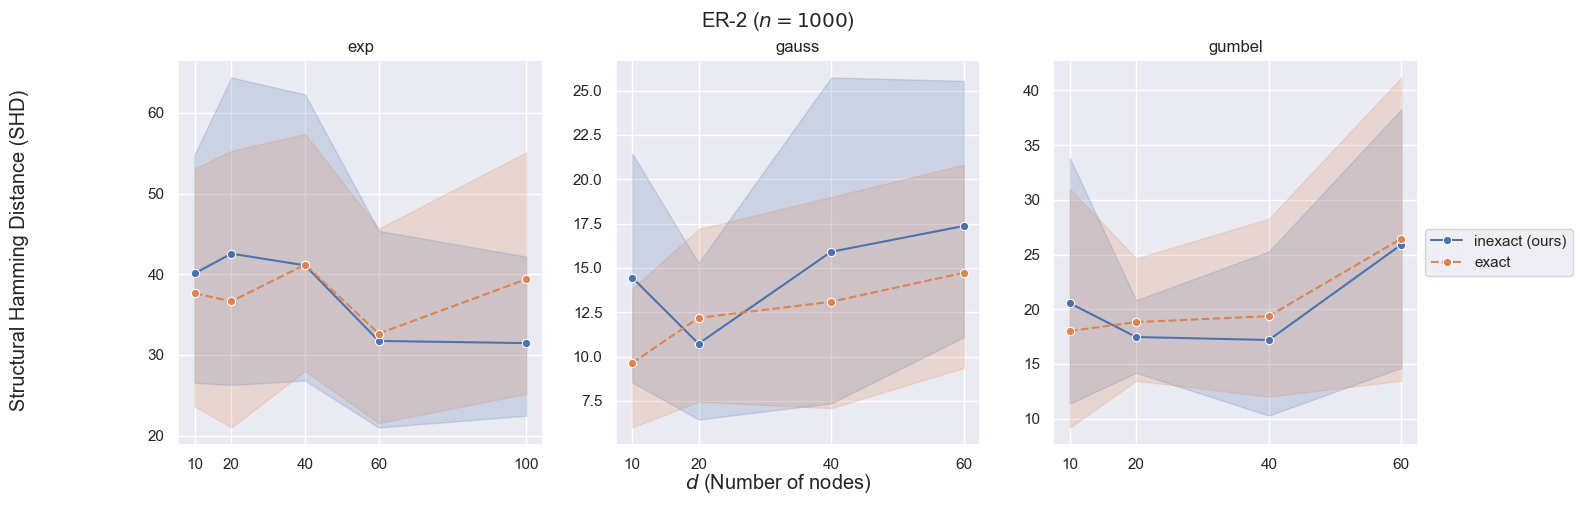

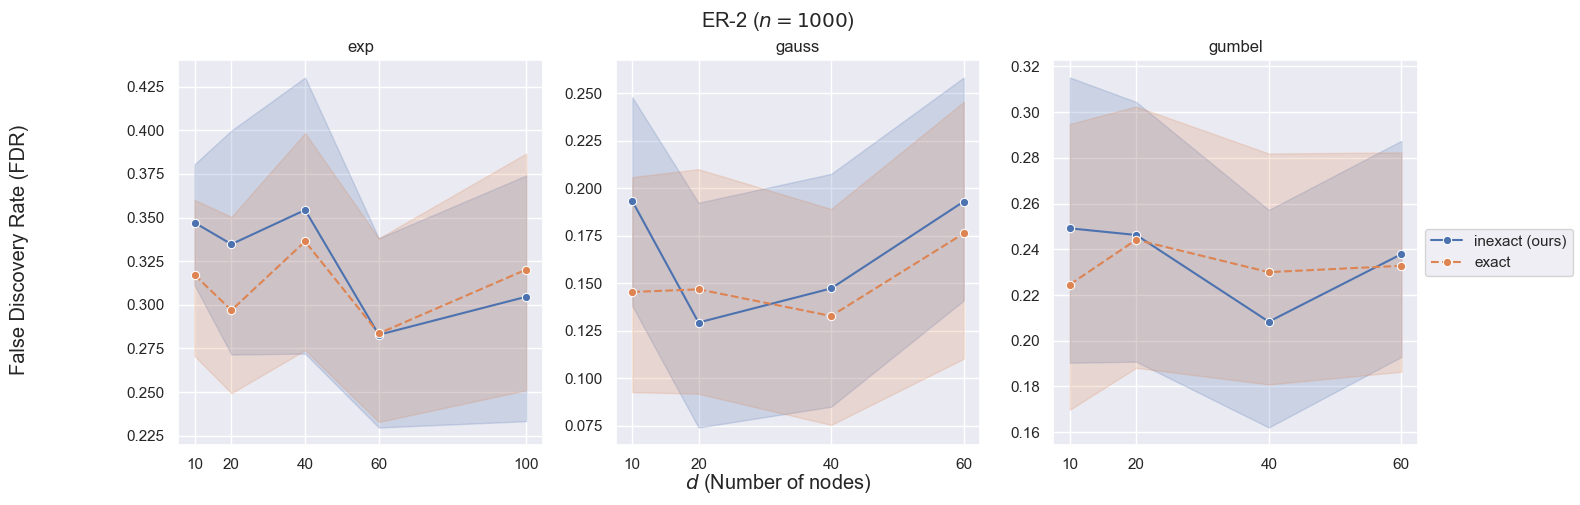

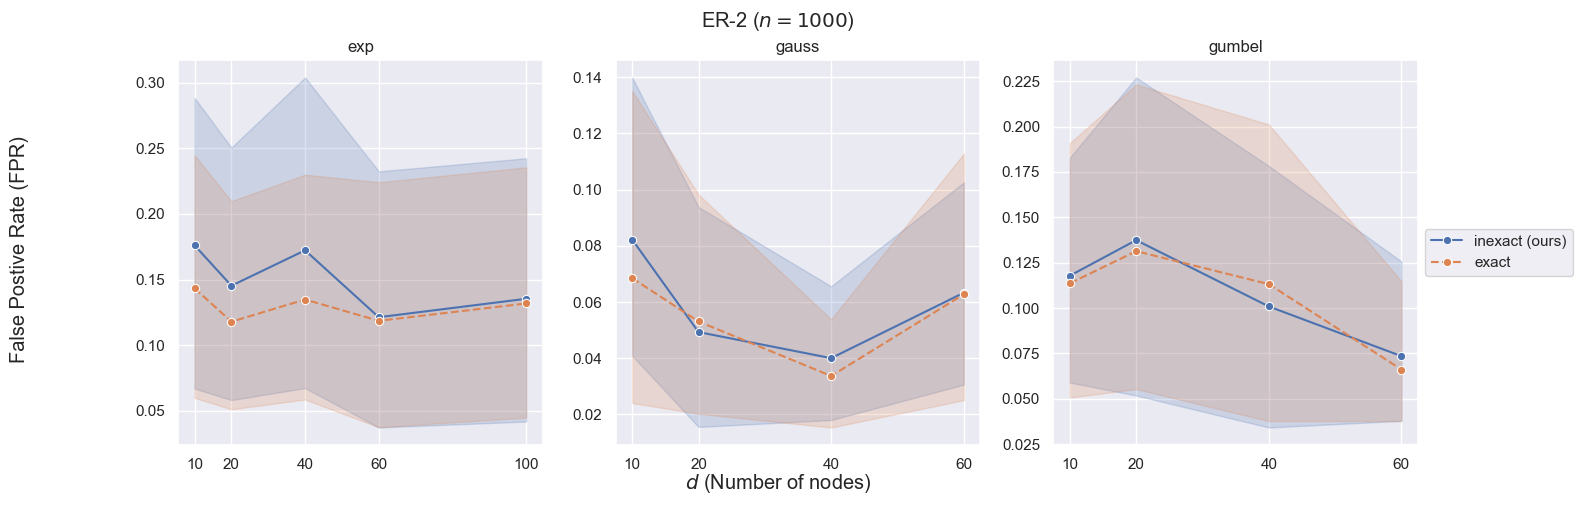

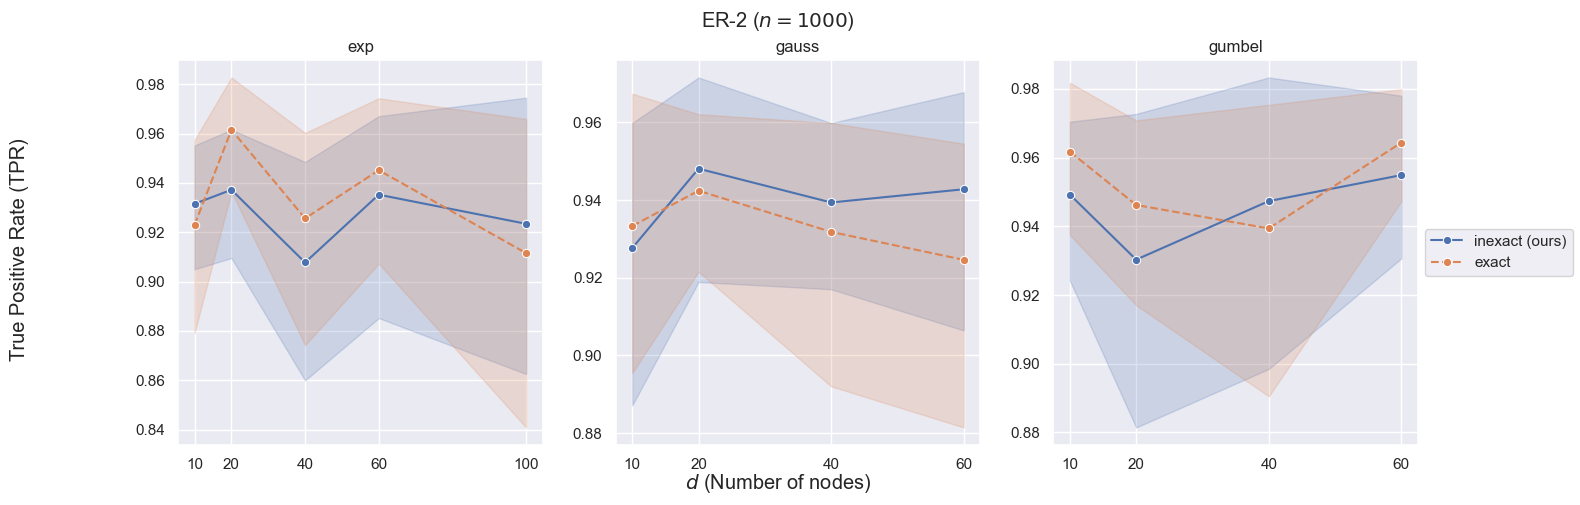

In [55]:
d_vals = [10, 20, 40, 60, 100]

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(16,5))
fig.suptitle(r'ER-2 ($n = 1000$)')
fig.supylabel('Structural Hamming Distance (SHD)')
fig.supxlabel(r'$d$ (Number of nodes)')
axes[0].set_title('exp')
axes[1].set_title('gauss')
axes[2].set_title('gumbel')

figFDR, axesFDR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figFDR.suptitle('ER-2 ($n = 1000$)')
figFDR.supylabel('False Discovery Rate (FDR)')
figFDR.supxlabel(r'$d$ (Number of nodes)')
axesFDR[0].set_title('exp')
axesFDR[1].set_title('gauss')
axesFDR[2].set_title('gumbel')

figFPR, axesFPR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figFPR.suptitle('ER-2 ($n = 1000$)')
figFPR.supylabel('False Postive Rate (FPR)')
figFPR.supxlabel(r'$d$ (Number of nodes)')
axesFPR[0].set_title('exp')
axesFPR[1].set_title('gauss')
axesFPR[2].set_title('gumbel')

figTPR, axesTPR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figTPR.suptitle('ER-2 ($n = 1000$)')
figTPR.supylabel('True Positive Rate (TPR)')
figTPR.supxlabel(r'$d$ (Number of nodes)')
axesTPR[0].set_title('exp')
axesTPR[1].set_title('gauss')
axesTPR[2].set_title('gumbel')


sns.lineplot(ax=axes[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_shd_results_ours, label= 'inexact (ours)', marker="o", err_style='band')
sns.lineplot(ax=axes[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_shd_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fdr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesFDR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fdr_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fpr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesFPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fpr_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_tpr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesTPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_tpr_results_original, label = 'exact', marker="o", linestyle = '--')


sns.lineplot(ax=axes[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_shd_results_ours, marker="o")
sns.lineplot(ax=axes[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_shd_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fdr_results_ours, marker="o")
sns.lineplot(ax=axesFDR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fdr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fpr_results_ours, marker="o")
sns.lineplot(ax=axesFPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fpr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_tpr_results_ours, marker="o")
sns.lineplot(ax=axesTPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_tpr_results_original, marker="o", linestyle = '--')


sns.lineplot(ax=axes[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_shd_results_ours, marker="o")
sns.lineplot(ax=axes[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_shd_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fdr_results_ours, marker="o")
sns.lineplot(ax=axesFDR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fdr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fpr_results_ours, marker="o")
sns.lineplot(ax=axesFPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fpr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_tpr_results_ours, marker="o")
sns.lineplot(ax=axesTPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_tpr_results_original, marker="o", linestyle = '--')


axes[0].get_legend().remove()
axesTPR[0].get_legend().remove()
axesFPR[0].get_legend().remove()
axesFDR[0].get_legend().remove()
fig.legend(loc='right')
figTPR.legend(loc='right')
figFDR.legend(loc='right')
figFPR.legend(loc='right')

axes[0].set_xticks(d_vals) # <--- set the ticks first
axes[0].set_xticklabels(d_vals)
axes[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axes[1].set_xticklabels(d_vals[:-1])
axes[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axes[2].set_xticklabels(d_vals[:-1])

axesTPR[0].set_xticks(d_vals) # <--- set the ticks first
axesTPR[0].set_xticklabels(d_vals)
axesTPR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesTPR[1].set_xticklabels(d_vals[:-1])
axesTPR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesTPR[2].set_xticklabels(d_vals[:-1])

axesFPR[0].set_xticks(d_vals) # <--- set the ticks first
axesFPR[0].set_xticklabels(d_vals)
axesFPR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFPR[1].set_xticklabels(d_vals[:-1])
axesFPR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFPR[2].set_xticklabels(d_vals[:-1])

axesFDR[0].set_xticks(d_vals) # <--- set the ticks first
axesFDR[0].set_xticklabels(d_vals)
axesFDR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFDR[1].set_xticklabels(d_vals[:-1])
axesFDR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFDR[2].set_xticklabels(d_vals[:-1])

In [21]:
# Calculate average run time
print("Gumbel")
print(np.array(gumbel_original_times).reshape(len(d_vals)-1, num_of_simulations+1).mean(axis = 1))
print(np.array(gumbel_our_times).reshape(len(d_vals)-1, num_of_simulations+1).mean(axis = 1))

print("Gauss")
print(np.array(gauss_original_times).reshape(len(d_vals)-1, num_of_simulations+1).mean(axis = 1))
print(np.array(gauss_our_times).reshape(len(d_vals)-1, num_of_simulations+1).mean(axis = 1))

print("Exp")
print(np.array(exp_original_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1))
print(np.array(exp_our_times).reshape(len(d_vals), num_of_simulations+1).mean(axis = 1))


Gumbel
[  1.58314709   8.83522708  80.62384748 146.82558961]
[  1.01036061   5.94352451  61.78342635 114.70302486]
Gauss
[  1.02044693   8.05894399  50.14485463 107.85603894]
[ 0.36984671  6.47550518 37.71423955 78.52777442]
Exp
[   2.29017451   10.68181361   79.50126873  174.33825354 1132.44921153]
[  1.15926357   8.50342196  62.38610357 132.84545049 878.6396666 ]


## Using real data

Exact Method

In [ ]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 7466, 11, 35, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = np.nan_to_num(np.load('Sachs.npy'))

In [ ]:
%%time
random.seed(1)
np.random.seed(1)
W_est, rhos, alphas, _ = solver.solve()

Iteration 1
2.777144045482446
Iteration 2
0.310446447565484
Iteration 3
0.07052444158863835
Iteration 4
0.015556087401105145
Iteration 5
0.003521536643987133
Iteration 6
0.0008236247270012598
Iteration 7
0.00020517487908655596
Iteration 8
1.4567909371265841e-05
Iteration 9
2.788024913158438e-06
Iteration 10
4.813155776162148e-07
Iteration 11
1.1124227228265227e-07
Iteration 12
6.849813516396352e-08
{'fdr': 0.41025641025641024, 'tpr': 0.6571428571428571, 'fpr': 0.8, 'shd': 23, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa75974a470>>
CPU times: user 43.9 s, sys: 46.4 s, total: 1min 30s
Wall time: 1min 1s


Inexact Method (ours)

In [ ]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X
random.seed(1)
np.random.seed(1)

In [ ]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ = solver2.solve()

Iteration 1
2.7761087331245733
Iteration 2
0.2358694744499541
Iteration 3
0.029924263498672943
Iteration 4
0.0031466656041843066
Iteration 5
0.000306368262890544
Iteration 6
3.7721298497217504e-05
Iteration 7
3.7908656036478305e-06
Iteration 8
4.705682172811976e-07
Iteration 9
8.666899375953108e-08
Iteration 10
8.666899375953108e-08
{'fdr': 0.4358974358974359, 'tpr': 0.6285714285714286, 'fpr': 0.85, 'shd': 25, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa7590d7310>>
CPU times: user 34.7 s, sys: 32.1 s, total: 1min 6s
Wall time: 39.7 s
